In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import cv2
import json

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
# load data
all_data= np.load(file="alldata_3D.npy")
all_lables=pd.read_csv('label.csv')
test_images=np.load(file='testdata_3D.npy')
test_lables=pd.read_csv('test_label.csv')

# create label multiclassification array 
labels=[]
test_labels=[]
for i in range(3000):
    data = all_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        labels.append(0)
    elif data == 'meningioma_tumor':
        #label.append('meningioma_tumor')
        labels.append(1)
    elif data == 'glioma_tumor':
        #label.append('glioma_tumor')
        labels.append(2)
    elif data == 'pituitary_tumor':
        #label.append('pituitary_tumor')
        labels.append(3)

for i in range(200):
    data = test_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        test_labels.append(0)
    elif data == 'meningioma_tumor':
        #label.append('meningioma_tumor')
        test_labels.append(1)
    elif data == 'glioma_tumor':
        #label.append('glioma_tumor')
        test_labels.append(2)
    elif data == 'pituitary_tumor':
        #label.append('pituitary_tumor')
        test_labels.append(3)
        
labels = np.array(labels)
test_labels =np.array(test_labels)

In [3]:
# Normalize the pixel value into a floating-point number between 0 and 1.
all_data = np.array(all_data, dtype="float") / 255.0 
test_images= np.array(test_images, dtype="float") / 255.0

# Direct adjustment of hyperparameter
INIT_LR = 0.001
EPOCHS = 50
BS = 16

# Divided into training set and verification set according to 8: 2
train_images,val_images,train_labels,val_labels=train_test_split(all_data,labels,test_size=0.2,random_state=0)

In [4]:
#Data Augmentation
aug=train_image_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                            height_shift_range=0.2,
                                            zoom_range=0.2,
                                            horizontal_flip=True,
                                            fill_mode='nearest')

In [5]:
#Call the pre-training Xception model
covn_base =keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224,224,3),pooling='avg')

#Build a model，use keras function
model = tf.keras.Sequential()
model.add(covn_base)
#model.add(tf.keras.layers.GlobalAveragePooling2D()) 
#model.add(tf.keras.layers.Dense(units=200,input_dim=784,activation='tanh',kernel_regularizer=l2(0.01)))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 20,815,148
Non-trainable params: 54,528
_________________________________________________________________


In [6]:
#complie and fit model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

#reduce the learning rate when the val_loss doesn't decrease
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1,min_lr=0.01*INIT_LR)
history =model.fit(aug.flow(train_images, train_labels, batch_size=BS), epochs=EPOCHS,validation_data=(val_images, val_labels),callbacks=[reduce_lr])

Epoch 1/20
150/150 [==============================] - 38s 203ms/step - loss: 0.6661 - accuracy: 0.7713 - val_loss: 1.1247 - val_accuracy: 0.6467
Epoch 2/20
150/150 [==============================] - 29s 191ms/step - loss: 0.4482 - accuracy: 0.8446 - val_loss: 1.3143 - val_accuracy: 0.7250
Epoch 3/20
150/150 [==============================] - 29s 191ms/step - loss: 0.3195 - accuracy: 0.8908 - val_loss: 0.8687 - val_accuracy: 0.8133
Epoch 4/20
150/150 [==============================] - 29s 192ms/step - loss: 0.2917 - accuracy: 0.9004 - val_loss: 0.5047 - val_accuracy: 0.8633
Epoch 5/20
150/150 [==============================] - 29s 191ms/step - loss: 0.2665 - accuracy: 0.9067 - val_loss: 0.7665 - val_accuracy: 0.8283
Epoch 6/20
150/150 [==============================] - 29s 191ms/step - loss: 0.2172 - accuracy: 0.9233 - val_loss: 0.5659 - val_accuracy: 0.8417

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
150/150 [============================

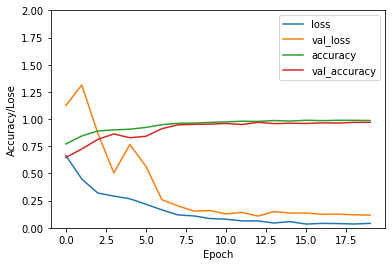

7/7 [==============================] - 1s 117ms/step - loss: 0.1545 - accuracy: 0.9650
0.9649999737739563 0.15446949005126953


In [7]:
#plot the curse and result
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lose')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(test_acc, test_loss)